In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Bioinformatics
from pysam import AlignmentFile

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rcParams['figure.dpi'] = 300

### Read ONT coverage

In [2]:
cov_ont = pd.read_csv(
    "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_ont = cov_ont.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ONT"})

In [10]:
cov_ont.describe()

,POS,COV_ONT
count,1.008248e+08,1.008248e+08
mean,8.529390e+06,8.749076e+02
std,5.071079e+06,2.209259e+02
min,0.000000e+00,0.000000e+00
25%,4.201034e+06,8.710000e+02
50%,8.402068e+06,9.450000e+02
75%,1.260310e+07,9.800000e+02
max,2.035478e+07,9.147000e+03


In [16]:
print(cov_ont["COV_ONT"].mode()[0])
print(cov_ont["COV_ONT"].median())
print(cov_ont["COV_ONT"].mean())

961
945.0
874.9076021929836


### Find reads spanning a deletion (not aligning in the middle)

In [17]:
def spanning_reads(bam_file, chromosome, start, left_break, right_break, end) :

    bam = AlignmentFile(bamf, "r")
    
    iter = bam.fetch(chromosome, start, end)

    spanning_reads_left = []
    spanning_reads_right = []
    spanning_reads = []
    
    for i, r in enumerate(iter) :
        if i % 10000 == 0 :
            print("Elapsed {} reads...".format(i))
        
        is_aligning_left = False
        is_aligning_right = False
        is_aligning_del = False

        for block in r.get_blocks() :
        
            if not is_aligning_left and min(block) <= left_break :
                is_aligning_left = True
            
            if not is_aligning_del and left_break <= int(np.mean(block)) <= right_break :
                is_aligning_del = True
            
            if not is_aligning_right and max(block) >= right_break :
                is_aligning_right = True
        
            if (is_aligning_left and is_aligning_del) or (is_aligning_del and is_aligning_right) :
                break
        
        if is_aligning_left and is_aligning_right and not is_aligning_del :
            spanning_reads.append(r.query_name)
            continue
        
        if is_aligning_left and not is_aligning_del :
            spanning_reads_left.append(r.query_name)
        
        if is_aligning_right and not is_aligning_del :
            spanning_reads_right.append(r.query_name)
            
    return spanning_reads_left, spanning_reads_right, spanning_reads

### Function to plot region

In [126]:
def plot_region_alignment(data, chrom, start, end, norm_factor=961, srange=5e4, plot_max_y=None) :
    
    pstart = start - 3e5
    pend = end + 3e5
    cdf = data.query("CHROM == @chrom & POS >= @pstart & POS <= @pend")
    
    bins = np.arange(pstart, pend, 1e4) # 10kb windows

    p = cdf["POS"].rolling(window=10000, step=5000, center=True).mean()
    cm = cdf["COV_ONT"].div(norm_factor).rolling(window=10000, step=5000, center=True).mean()
    cs = cdf["COV_ONT"].div(norm_factor).rolling(window=10000, step=5000, center=True).std()

    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(p, cm, zorder=10)
    ax.fill_between(p, cm-cs, cm+cs, alpha=0.25, zorder=5)

    miny = np.min(cm-cs)
    maxy = np.max(cm+cs)

    ax.axhline([1.0], color="k", zorder=3, lw=0.5)
    ax.vlines([start, end], ymin=miny, ymax=maxy, color="k", lw=0.75)
    
    middle = int(start + (end-start)/2)
    ss1, ss2 = start - srange, start + srange
    se1, se2 = end - srange, end + srange
    
    ax.vlines([ss1, ss2, middle, se1, se2], ymin=miny, ymax=maxy, color="k", linestyle="dashed", lw=0.5)

    ax.fill_between([min(p.dropna()), ss1], miny, maxy, zorder=1, alpha=0.2, color="orange", lw=0.0)
    ax.fill_between([ss1, ss2], miny, maxy, zorder=1, alpha=0.2, color="green", lw=0.0)
    ax.fill_between([ss2, se1], miny, maxy, zorder=1, alpha=0.2, color="red", lw=0.0)
    ax.fill_between([se1, se2], miny, maxy, zorder=1, alpha=0.2, color="green", lw=0.0)
    ax.fill_between([se2, max(p.dropna())], miny, maxy, zorder=1, alpha=0.2, color="orange", lw=0.0)

    ax.set_ylabel("Coverage")
    ax.set_xlabel("Position")
    ax.grid(axis="y", zorder=1)

    if plot_max_y is not None :
        ax.set_ylim(0.0, plot_max_y)
    
    plt.show()
    
    print("Region for reads: {:d}-{:d} and {:d}-{:d}".format(int(ss1),int(ss2), int(se1),int(se2)))
    
    return cdf

### Functions to plot alignments of spanning reads

In [109]:
def get_blocks_of_specific_read_in_region(bam_file, read_name, chromosome, start, end) :
    
    read_alignments = []
    length = None
    
    bam = AlignmentFile(bamf, "r")
    iter = bam.fetch(chromosome, start, end)
    
    for i, r in enumerate(iter) :
        if r.query_name != read_name :
            continue
        else :
            
            ref_start, ref_end = r.reference_start, r.reference_end
            qry_start, qry_end = r.query_alignment_start, r.query_alignment_end
            
            read_alignments.append({
                "rs":ref_start, "re":ref_end,
                "qs":qry_start, "qe":qry_end,
            })
            
            if length is None :
                length = r.infer_query_length()
    
    return read_alignments, length

In [114]:
def plot_all_aligned_segments(read_alignments, start, end, read_length) :
    
    size_ref = end-start+1
    proportion_size_read = read_length / size_ref    
    factor = 8.0
    
    fig, ax = plt.subplots(figsize=(factor, factor * proportion_size_read))
    
    for aln in read_alignments :
        
        ax.plot([aln["rs"], aln["re"]], [aln["qs"], aln["qe"]])
    
    ax.set_ylim(0, end-start+1)
    ax.set_ylim(0, read_length)
    
    ax.set_ylabel("Read")
    ax.set_xlabel("Reference")
    
    plt.show()

## Chromosome 1 deletion A

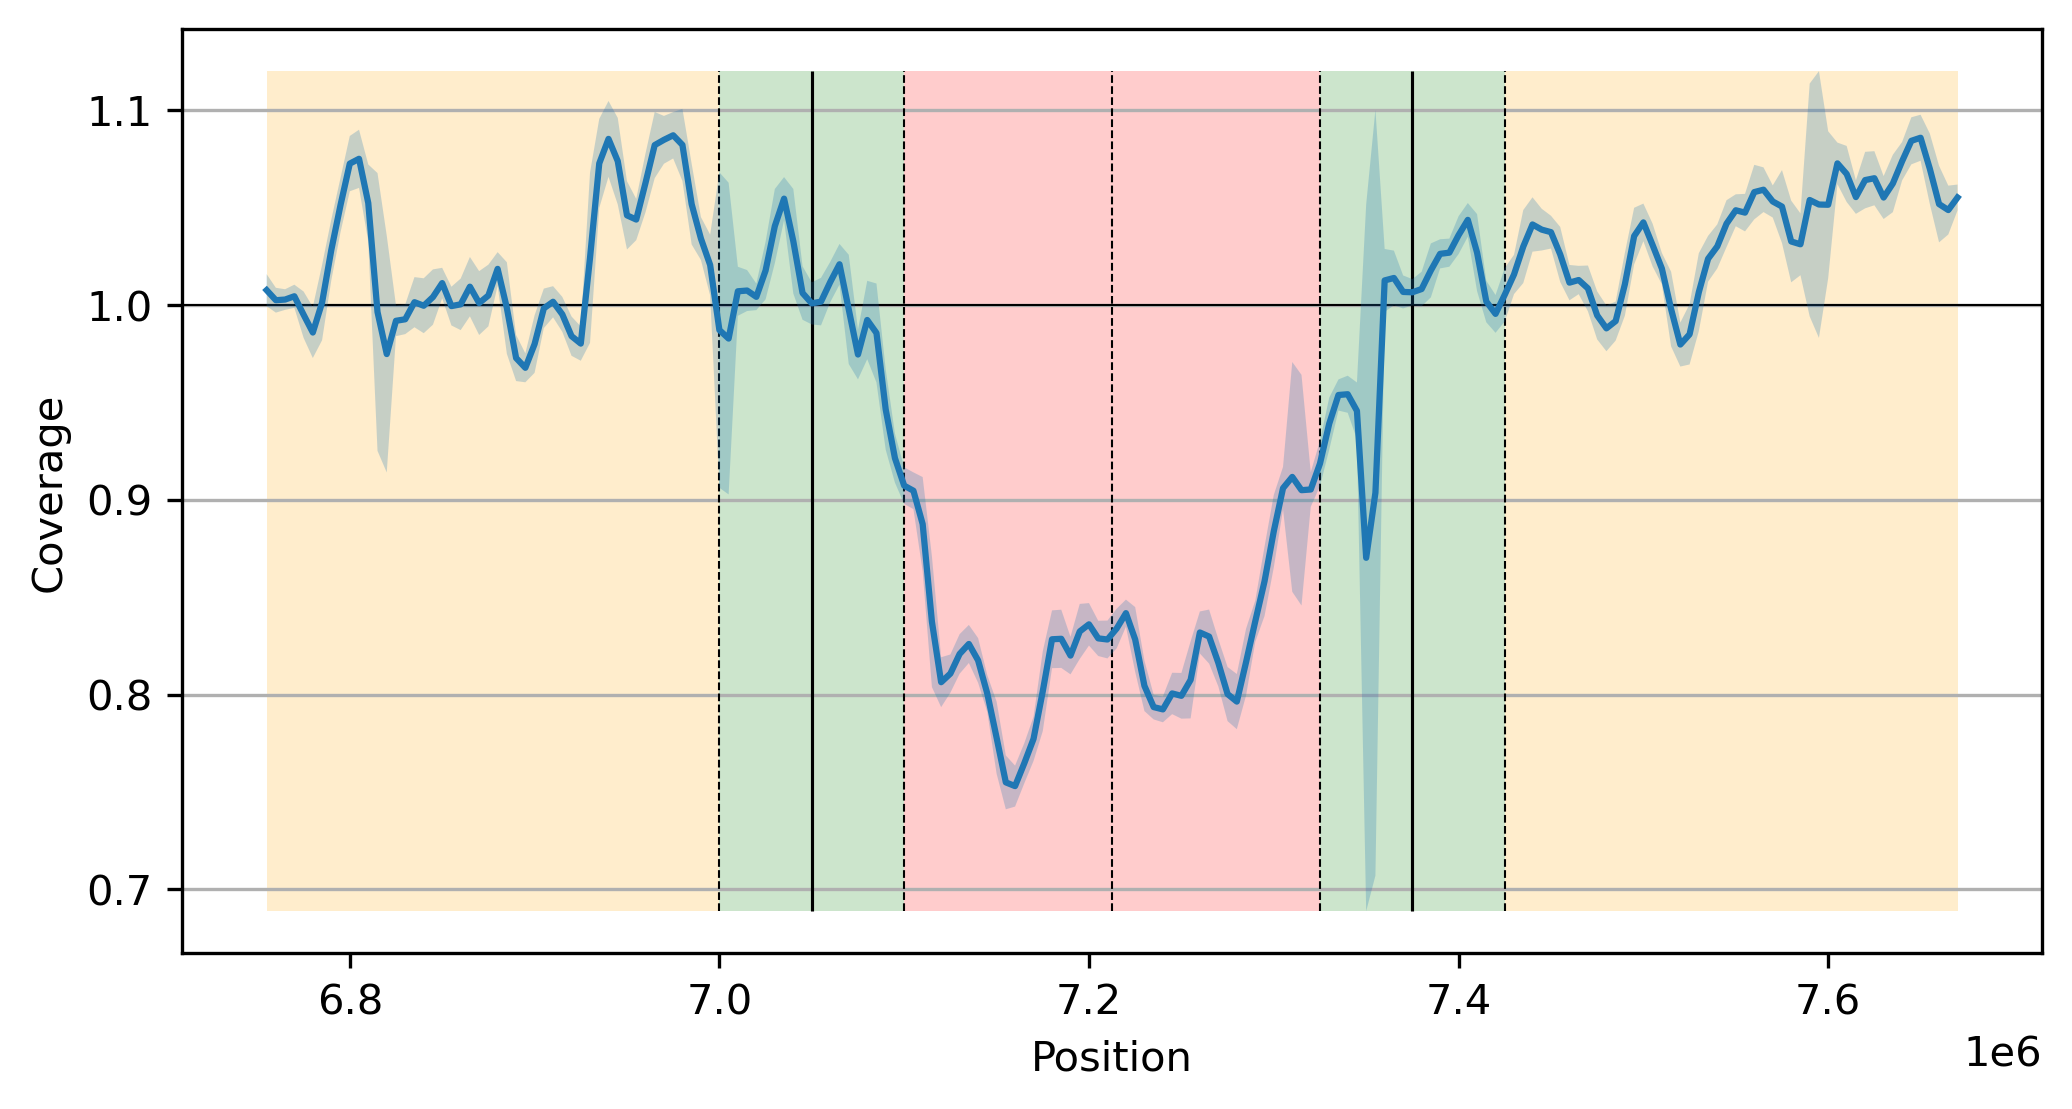

Region for reads: 7000000-7100000 and 7325000-7425000


In [100]:
cdf = plot_region_alignment(cov_ont, "Chrom_1", 7050000, 7375000)

In [104]:
bamf = "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.bam"
start, left_break, right_break, end = 7000000, 7100000, 7325000, 7425000

srl, srr, sr = spanning_reads(bamf, "Chrom_1", start, left_break, right_break, end)
sr_spanning = list(set(sr + [read for read in srl if read in srr]))
sr_spanning

Elapsed 0 reads...
Elapsed 10000 reads...
Elapsed 20000 reads...


['de8ed647-87aa-4bc2-b3ef-60eb088d92c8']

In [110]:
bamf = "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.bam"
read = 'de8ed647-87aa-4bc2-b3ef-60eb088d92c8'
chrom = "Chrom_1"
start, end = 7020000, 7385000

read_alignments, read_length = get_blocks_of_specific_read_in_region(bamf, read, chrom, start, end)

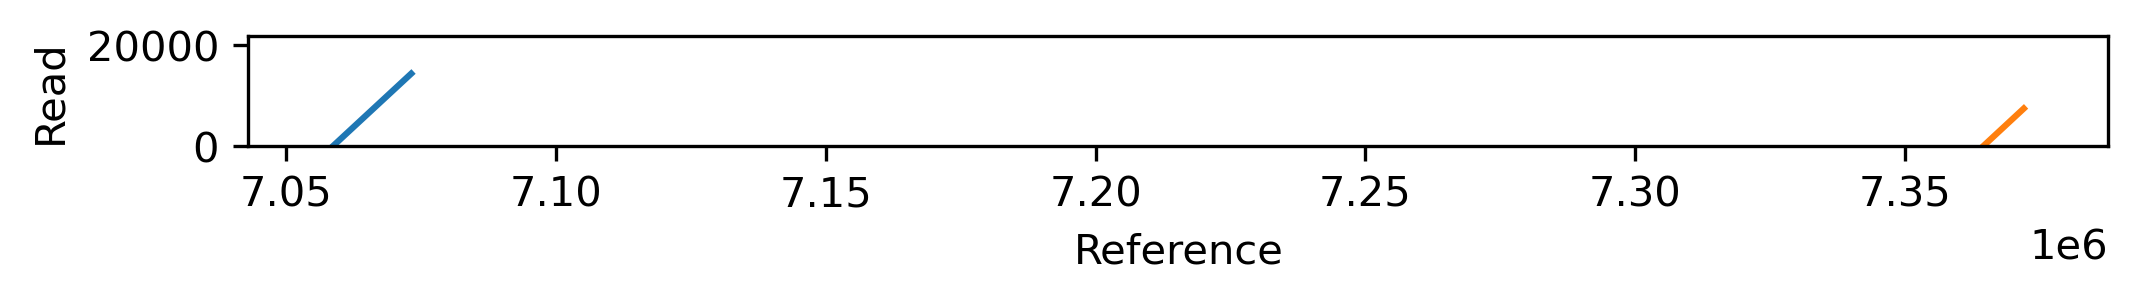

In [115]:
plot_all_aligned_segments(read_alignments, start, end, read_length)

## Chromosome 6 deletion A

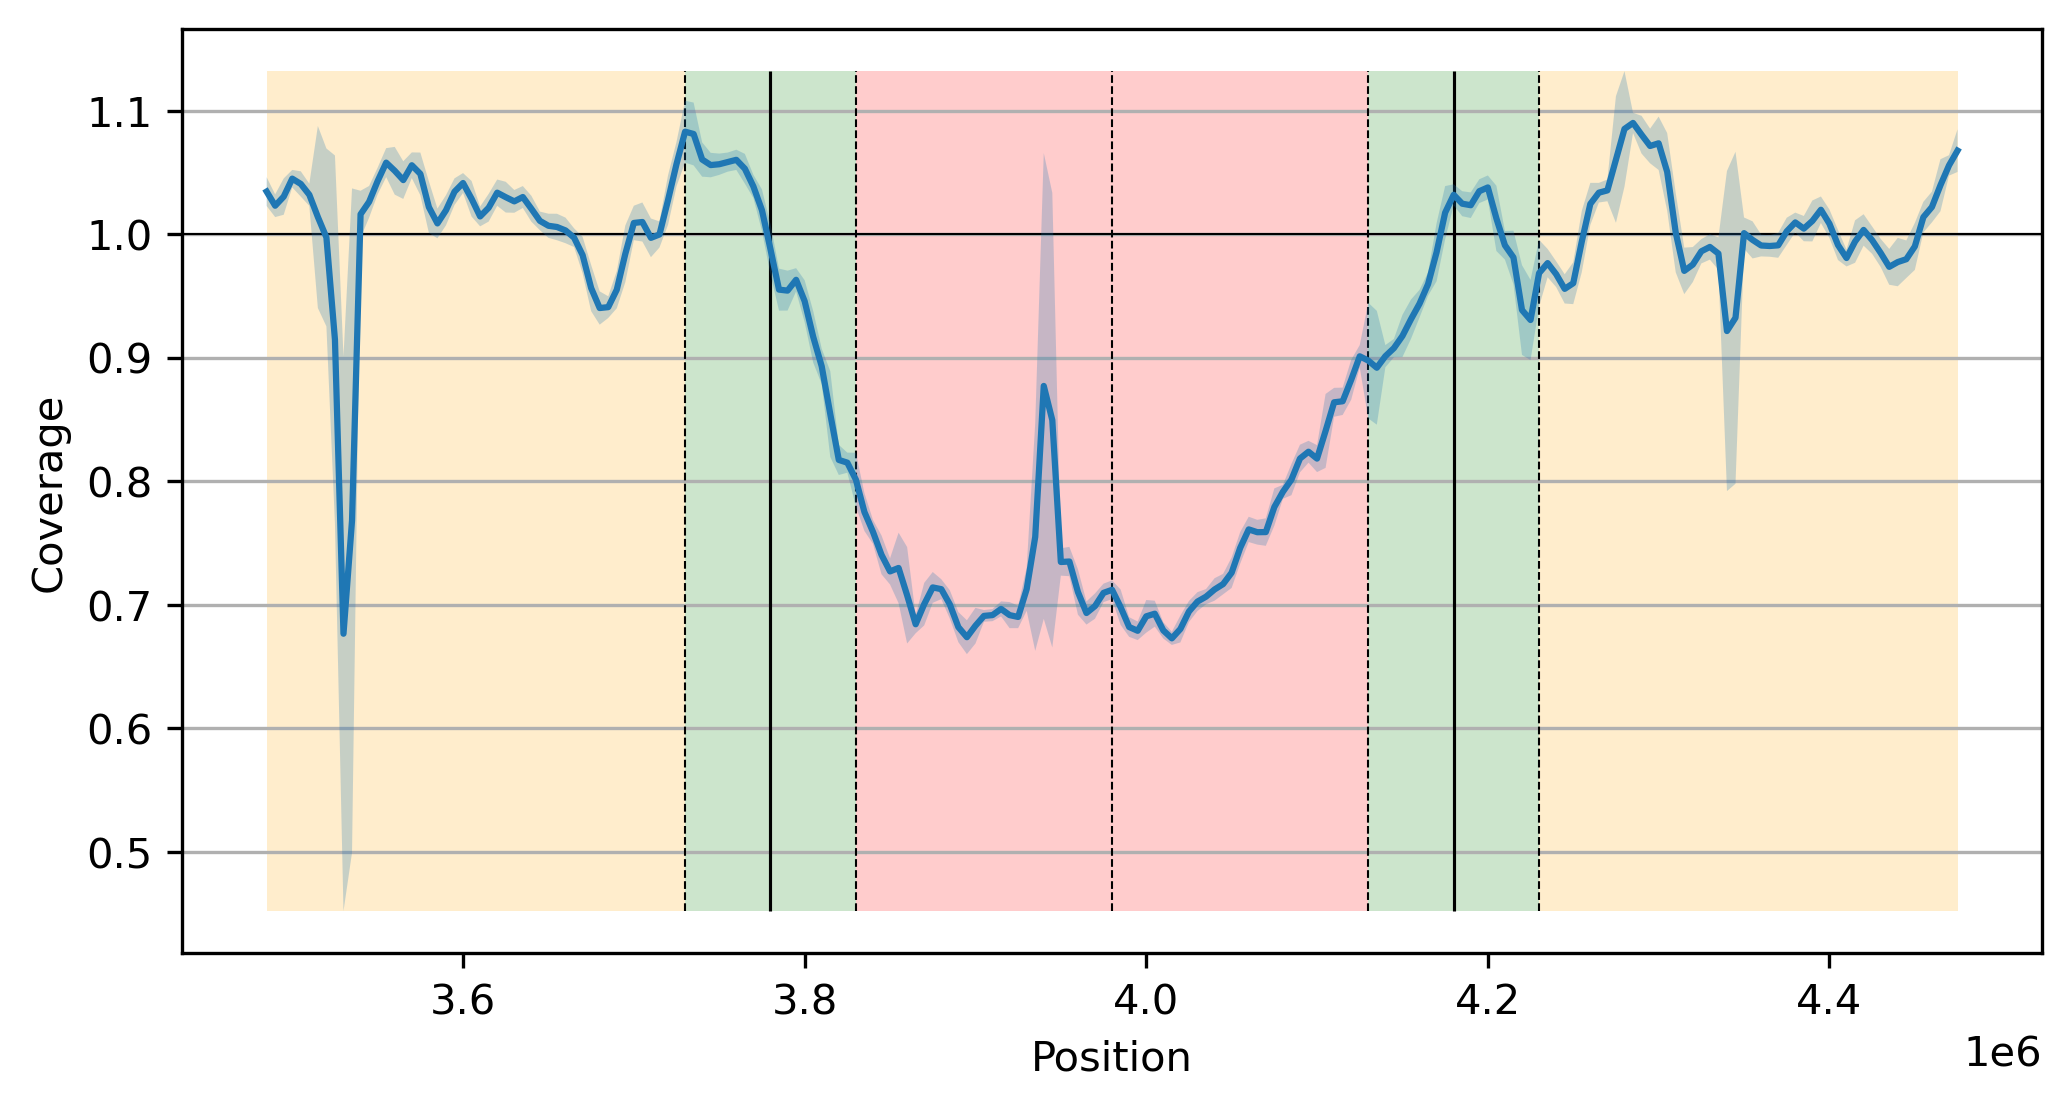

Region for reads: 3730000-3830000 and 4130000-4230000


In [119]:
cdf = plot_region_alignment(cov_ont, "Chrom_6", 3780000, 4180000)

In [120]:
bamf = "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.bam"
start, left_break, right_break, end = 3730000, 3830000, 4130000, 4230000

srl, srr, sr = spanning_reads(bamf, "Chrom_6", start, left_break, right_break, end)
sr_spanning = list(set(sr + [read for read in srl if read in srr]))
sr_spanning

Elapsed 0 reads...
Elapsed 10000 reads...
Elapsed 20000 reads...


[]

No reads spanning found...

## Chromosome 4 deletion A

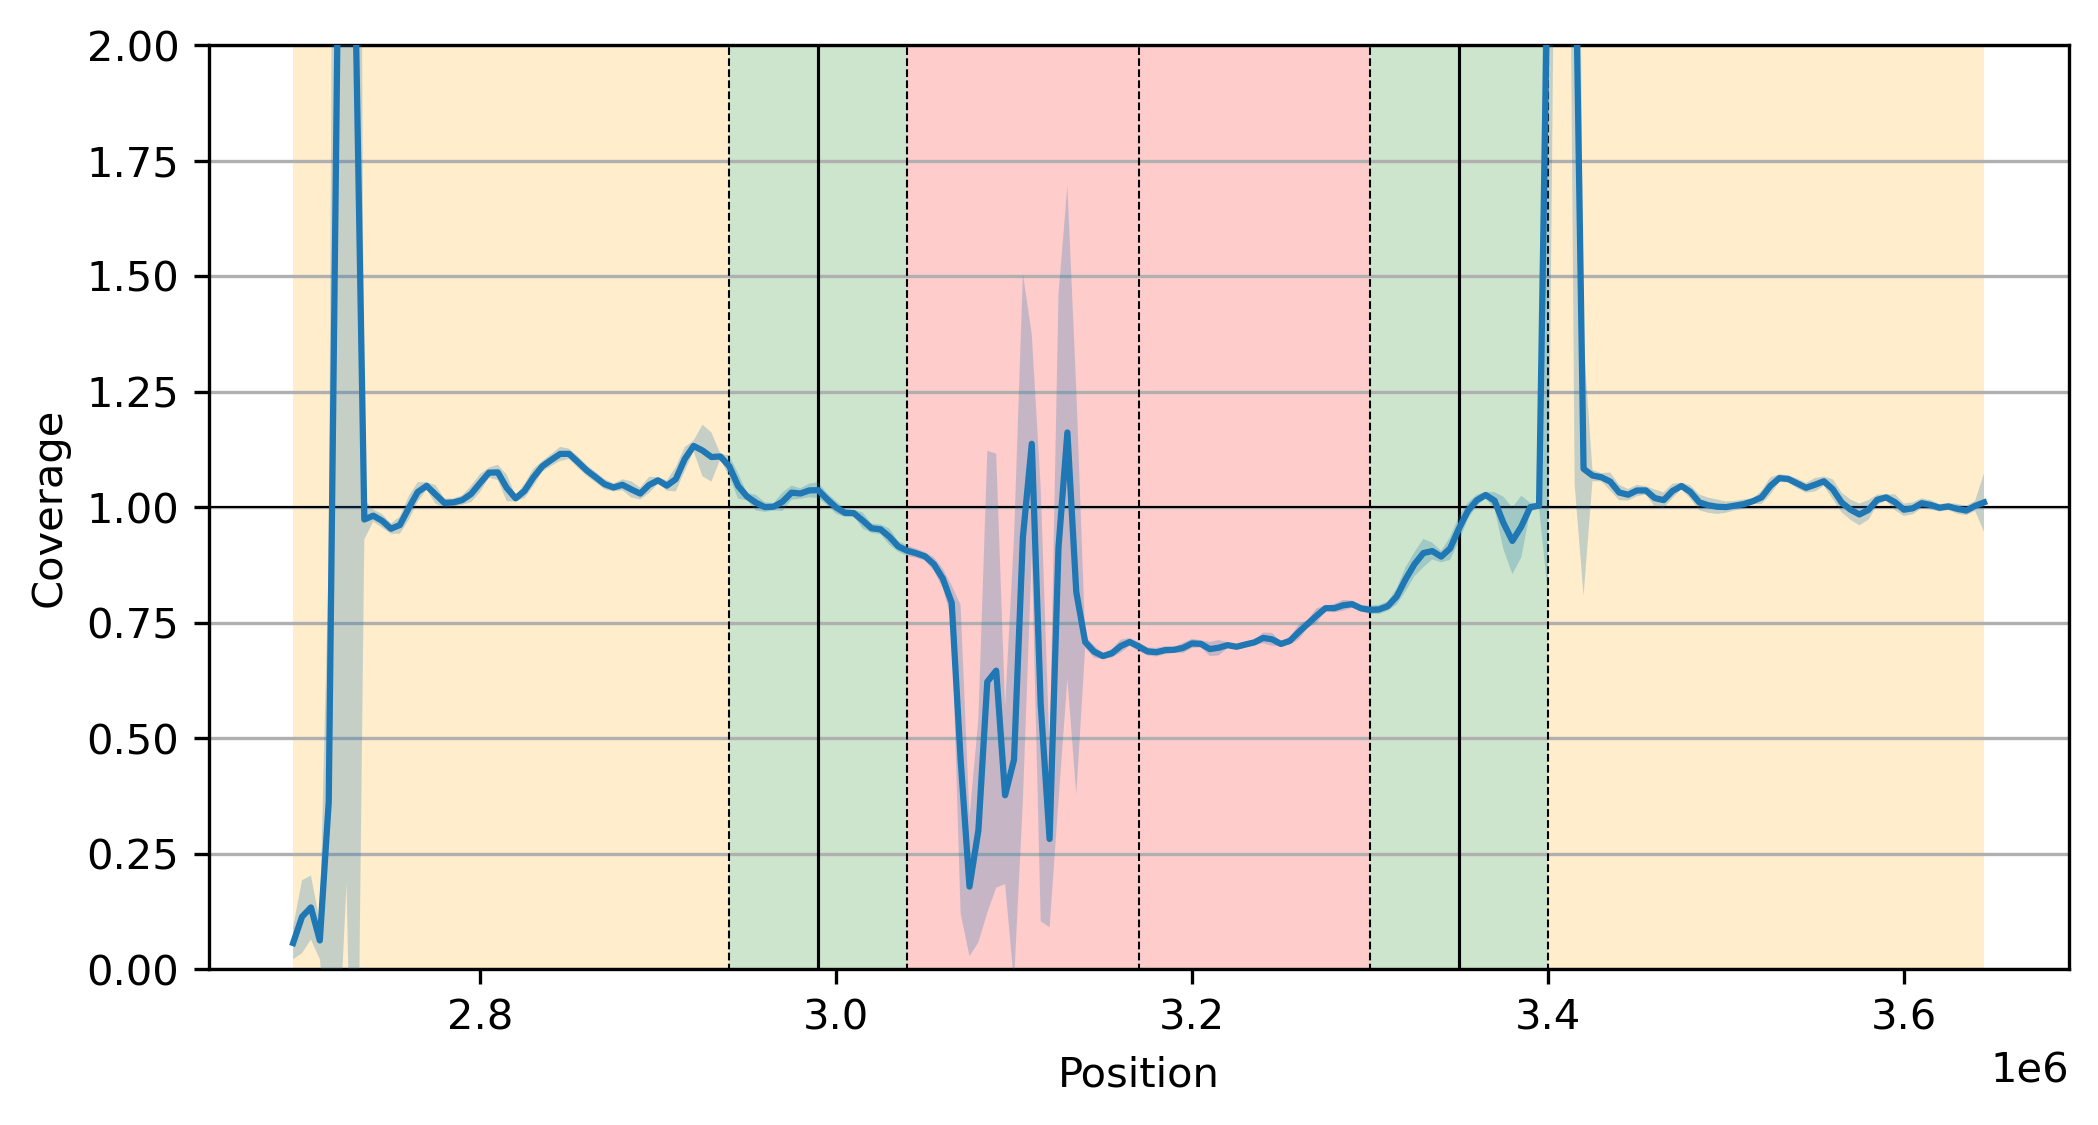

Region for reads: 2940000-3040000 and 3300000-3400000


In [129]:
cdf = plot_region_alignment(cov_ont, "Chrom_4", 2990000, 3350000, plot_max_y=2.0)

In [130]:
bamf = "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.bam"
start, left_break, right_break, end = 2940000, 3040000, 3300000, 3400000

srl, srr, sr = spanning_reads(bamf, "Chrom_4", start, left_break, right_break, end)
sr_spanning = list(set(sr + [read for read in srl if read in srr]))
sr_spanning

Elapsed 0 reads...
Elapsed 10000 reads...
Elapsed 20000 reads...
Elapsed 30000 reads...


[]

## Chromosome 3 deletion A

No reads spanning found...

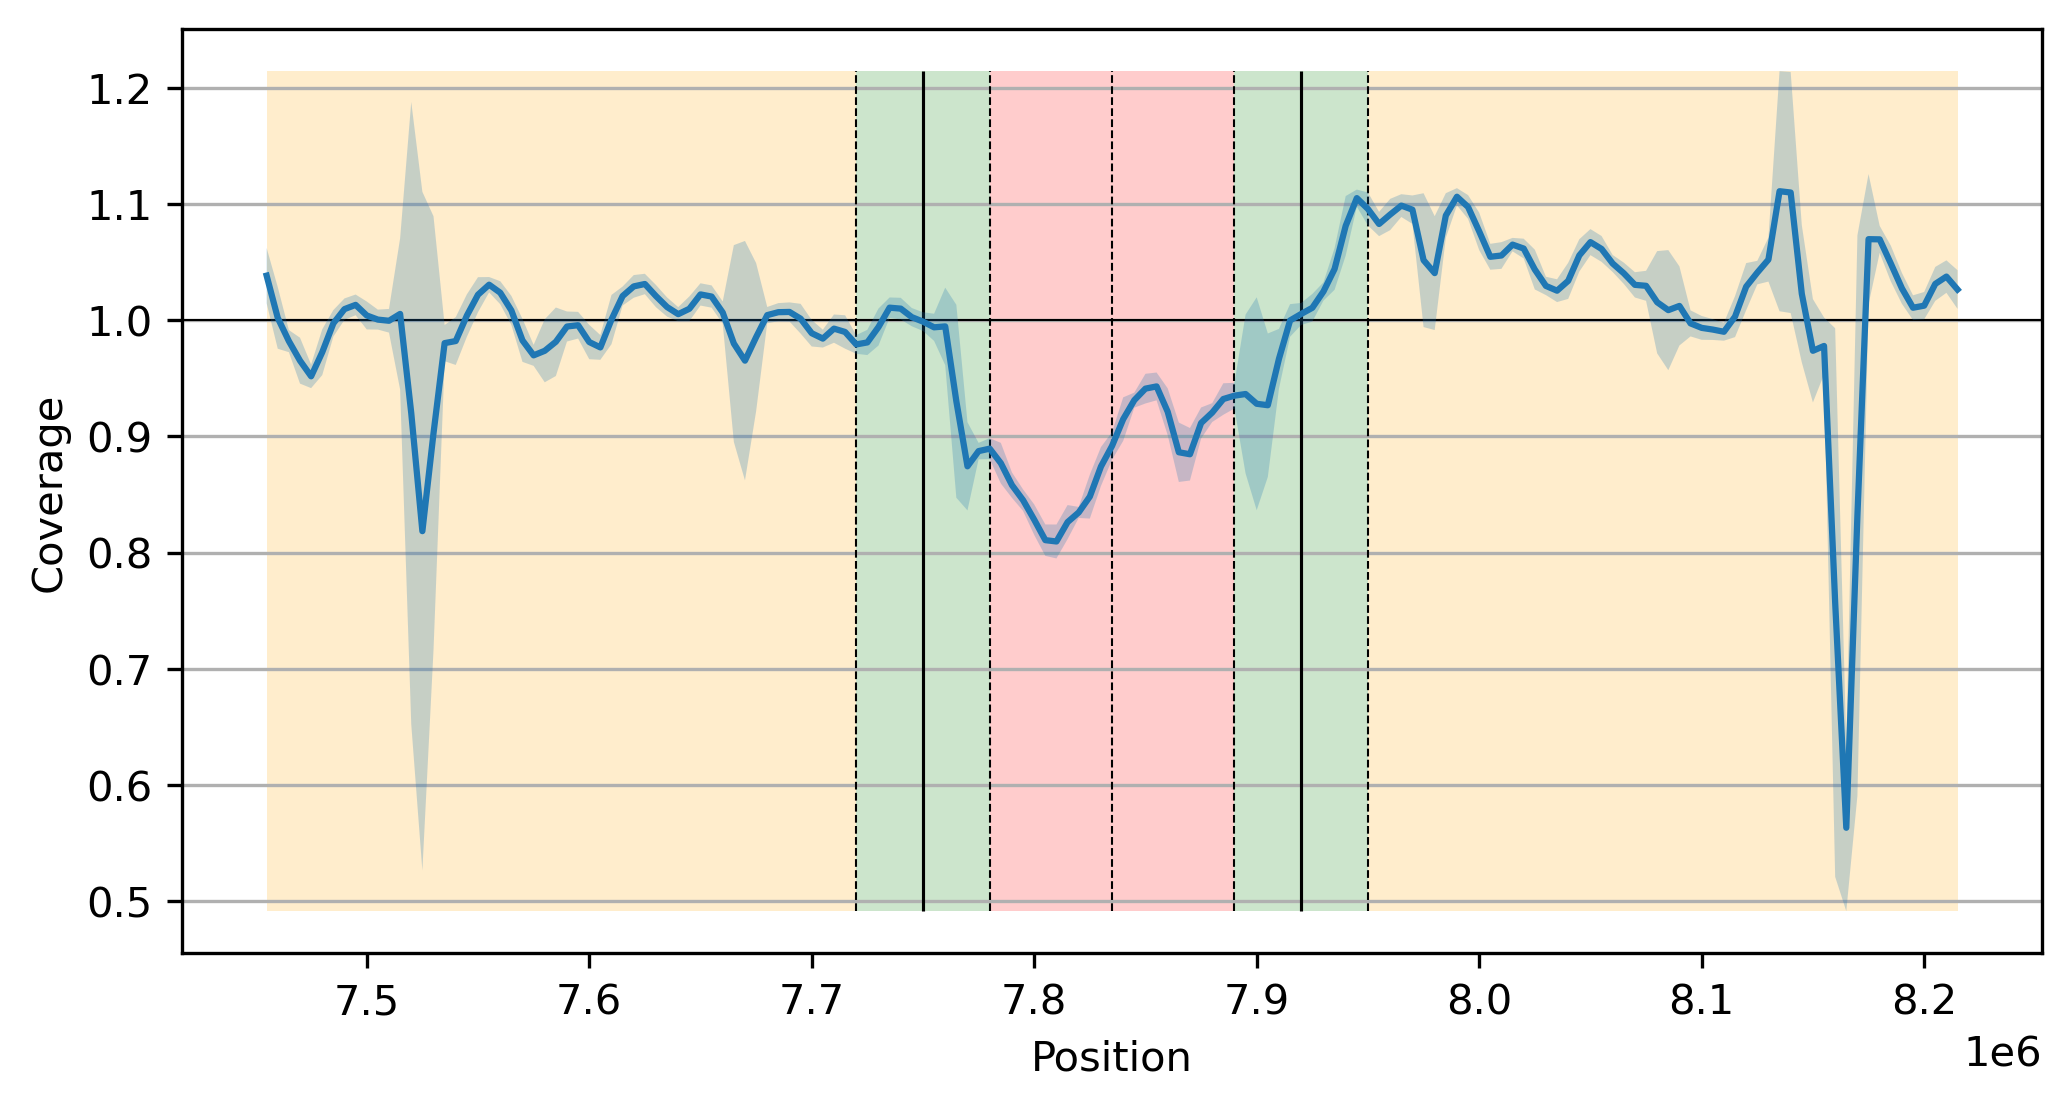

Region for reads: 7720000-7780000 and 7890000-7950000


In [132]:
cdf = plot_region_alignment(cov_ont, "Chrom_3", 7750000, 7920000, srange=3e4)

In [133]:
bamf = "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.bam"
start, left_break, right_break, end = 7720000,7780000, 7890000,7950000

srl, srr, sr = spanning_reads(bamf, "Chrom_3", start, left_break, right_break, end)
sr_spanning = list(set(sr + [read for read in srl if read in srr]))
sr_spanning

Elapsed 0 reads...
Elapsed 10000 reads...


['c5939b64-ba54-45f9-bfc4-643845cc0371',
 '26f2ba78-3c7c-441d-92bd-ba012a518104',
 'b3b9605f-b131-4bce-8c27-7dade07fd7a9',
 '355cf35e-f701-407d-b5af-6e7997c331c8',
 '41992ab7-b8eb-47d0-a791-003bca192006',
 'b2dd65c4-c193-44e5-ab14-f048bcbb1ab1',
 'dae5a33e-7fa6-4a1c-b08f-307a55c0d19b',
 '940c23c0-791c-404b-83fb-9fdf6de5348c',
 '4a222c3f-bbea-4c36-9fbe-ee29a9d56304',
 '9f4356c8-a4b9-4eeb-af8c-f5879a6faac3',
 '18e70c56-a385-4622-a293-b79f3e862e13',
 '464fa19e-a6dd-444c-b194-cb8270c50fb9',
 '1e324c6e-7c00-4676-9776-e0efddae8885',
 '25a91930-caf7-4834-bfa6-c808d3fd01c9',
 '9ae64ecb-c2aa-4060-975e-999436fc1775',
 '156e5c31-8dd8-4dca-af34-a7b004707ff0',
 '469adaf4-aea8-4a6c-9092-e2da72b89911',
 '3e1bafcf-a6fe-4fb2-a727-ab8121a0a530',
 'd1b1f2bd-7021-44b7-a87b-fde4ecc85dad',
 '6bee7037-1c8c-490a-9477-60690b913c85',
 '97ffa610-5816-44ae-89d1-f84cc794320b',
 'd945c945-17f9-4570-bec1-77f3f07d8fc4',
 'e0440360-c59c-470a-8ab0-22fd29b56e9b',
 'c8b54dd3-bb5d-4d6f-a5f0-7fc2f1d18fe8',
 '08341ad7-b418-

In [136]:
def plot_all_reads(bamf, all_reads, chrom, start, end) :
    
    for read in all_reads :
        print(read)
        read_alignments, read_length = get_blocks_of_specific_read_in_region(bamf, read, chrom, start, end)
        print(read_alignments, read_length)
        plot_all_aligned_segments(read_alignments, start, end, read_length)

94ad49f0-1bf4-4e96-b30f-6d470d7595ed
[{'rs': 7763438, 're': 7764720, 'qs': 5666, 'qe': 6951}, {'rs': 7881739, 're': 7898488, 'qs': 26, 'qe': 16631}, {'rs': 7899779, 're': 7905439, 'qs': 17921, 'qe': 23570}] 23586


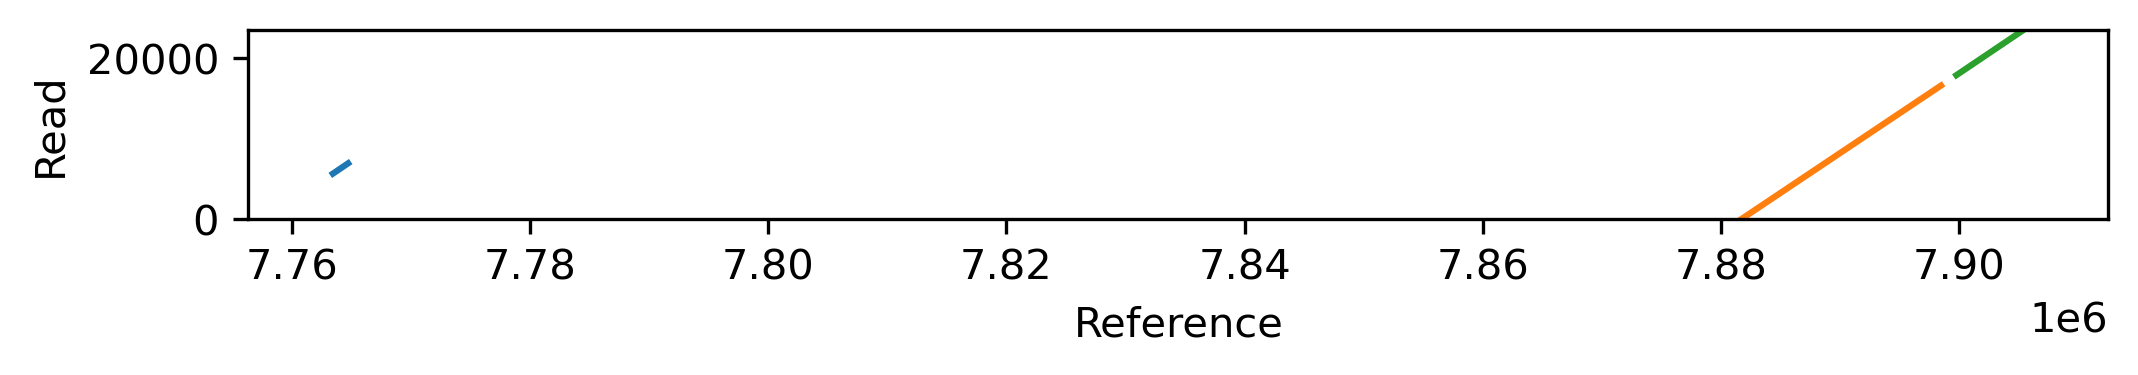

cc17be34-03c8-4b55-918e-127d9246e217
[{'rs': 7742671, 're': 7765164, 'qs': 8, 'qe': 22363}, {'rs': 7766193, 're': 7777990, 'qs': 23387, 'qe': 35138}, {'rs': 7897025, 're': 7898049, 'qs': 11775, 'qe': 12800}] 35163


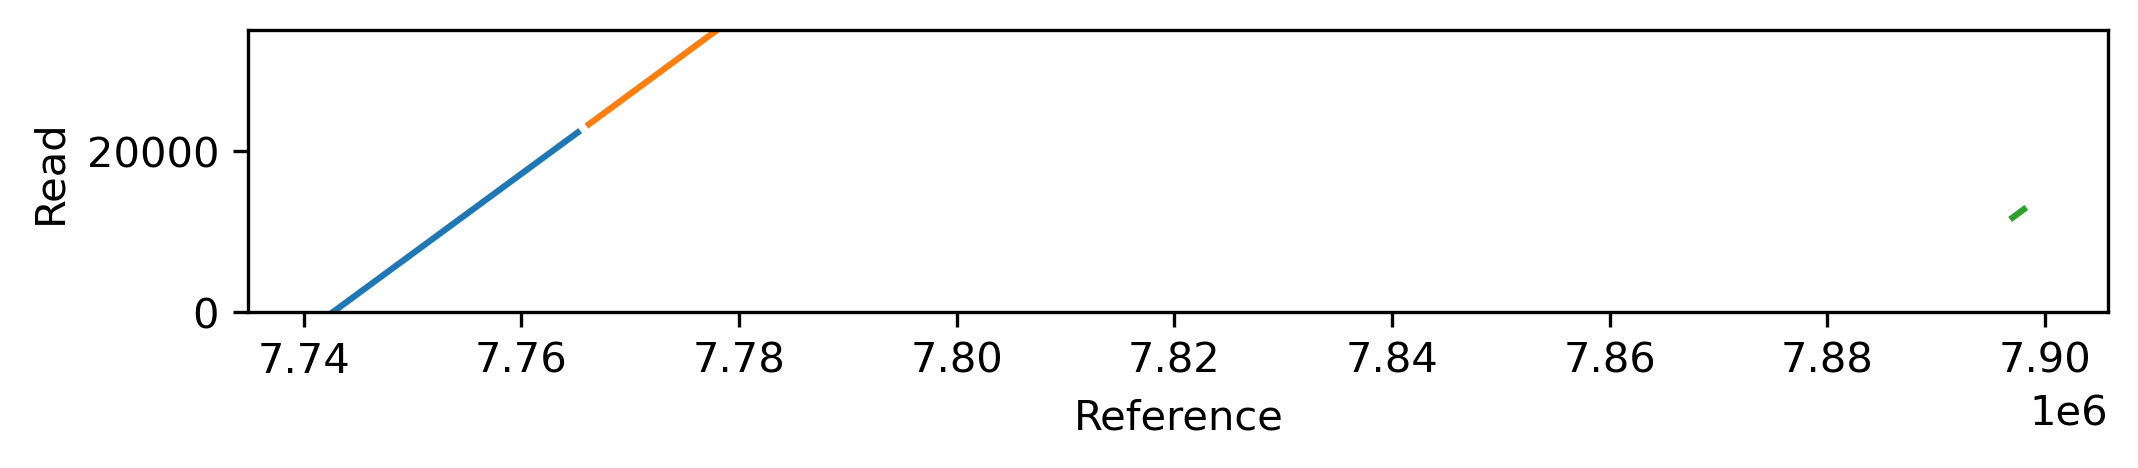

21653683-29f9-40a2-b217-c0c6a23c73be
[{'rs': 7767657, 're': 7767976, 'qs': 6963, 'qe': 7280}, {'rs': 7895576, 're': 7902555, 'qs': 766, 'qe': 7695}] 7710


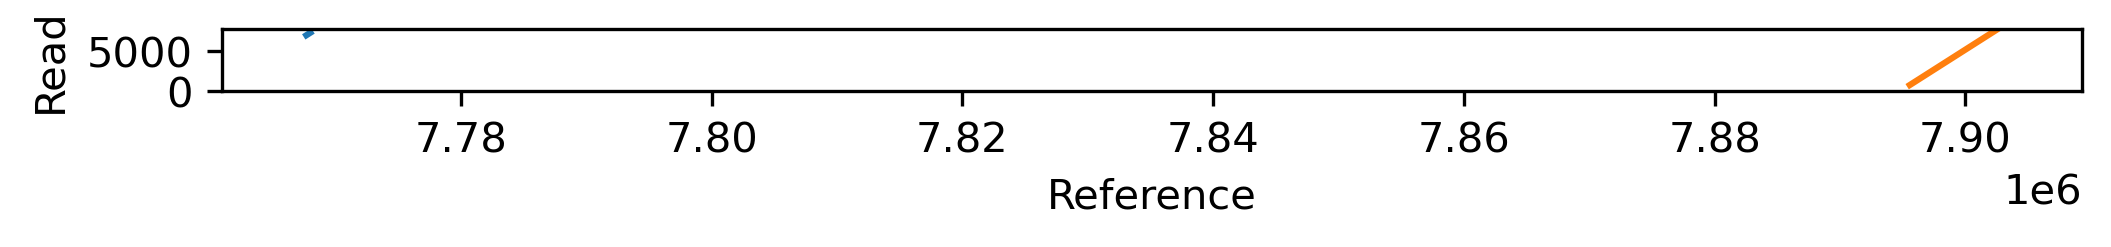

53d7ac27-9783-4a1b-96e4-4281d5923e52
[{'rs': 7762476, 're': 7764030, 'qs': 8188, 'qe': 9728}, {'rs': 7887267, 're': 7899186, 'qs': 11, 'qe': 11888}, {'rs': 7900732, 're': 7908956, 'qs': 13427, 'qe': 21587}] 21616


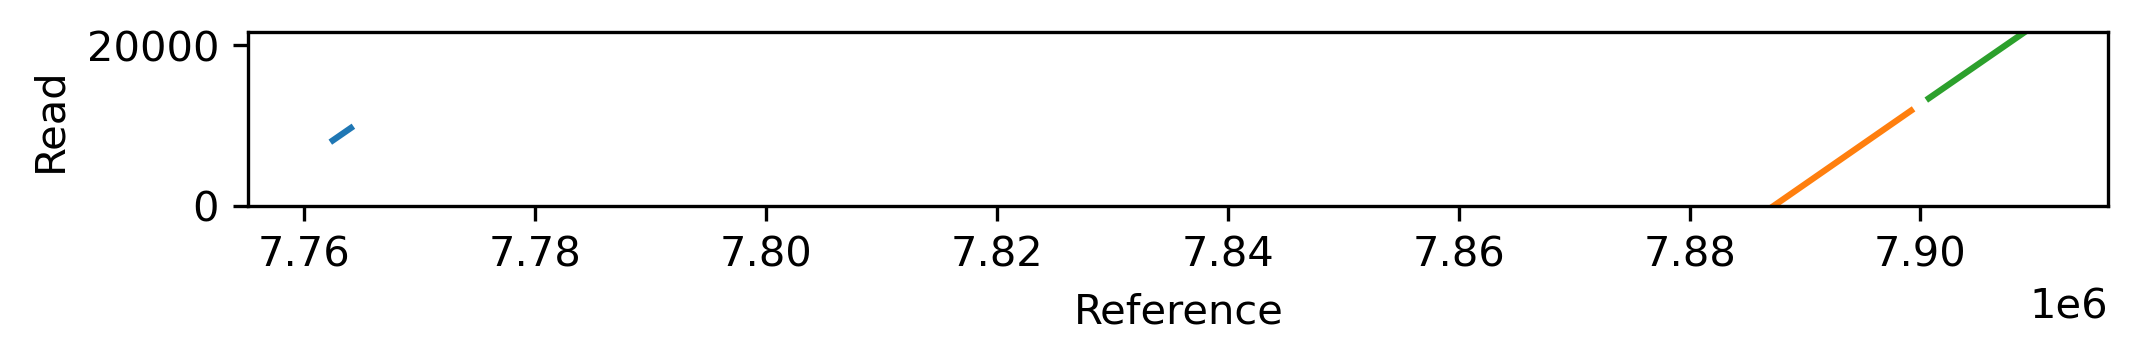

9afad274-3bdf-4daa-93c3-a8f774fd0845
[{'rs': 7764703, 're': 7765297, 'qs': 10114, 'qe': 10704}, {'rs': 7890876, 're': 7897657, 'qs': 32, 'qe': 6625}, {'rs': 7898534, 're': 7908690, 'qs': 7500, 'qe': 17557}] 17597


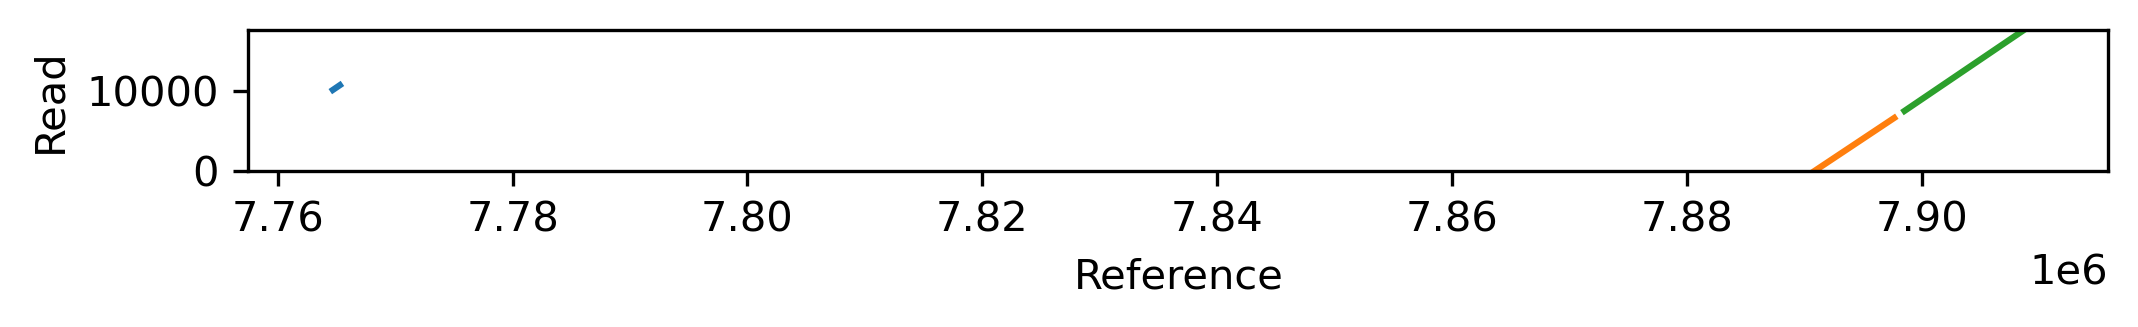

e070109b-dd61-45db-aad1-067e267154eb
[{'rs': 7763322, 're': 7764397, 'qs': 2162, 'qe': 3229}, {'rs': 7881555, 're': 7898816, 'qs': 29, 'qe': 17122}, {'rs': 7899888, 're': 7902121, 'qs': 18184, 'qe': 20347}] 20355


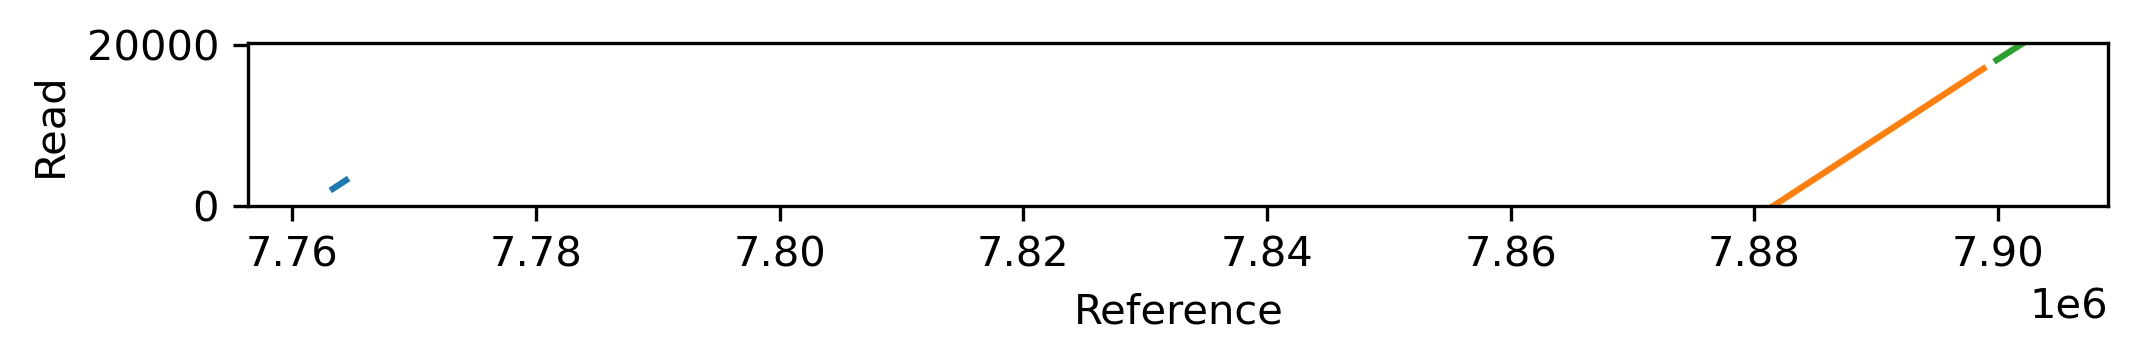

c878714f-a994-4973-942b-6931df6472fd
[{'rs': 7763666, 're': 7764182, 'qs': 6502, 'qe': 7016}, {'rs': 7881327, 're': 7899035, 'qs': 28, 'qe': 17664}, {'rs': 7899550, 're': 7906184, 'qs': 18177, 'qe': 24665}] 24679


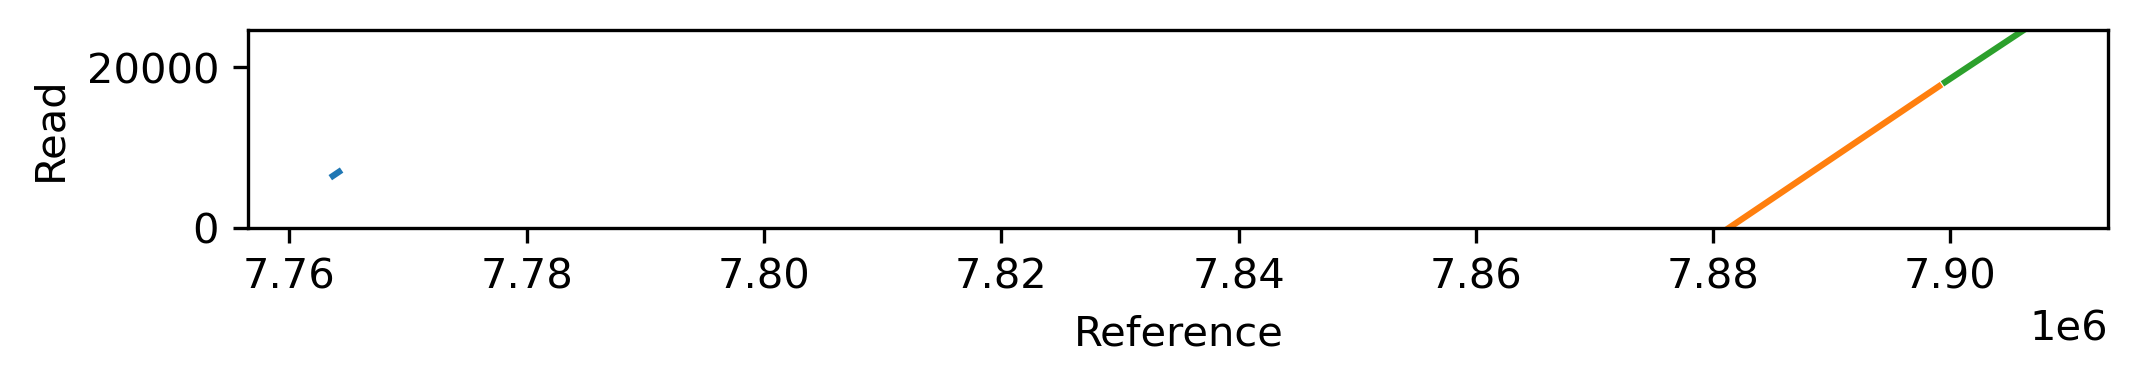

b7bf35d1-5df4-47ee-b5d4-88a830833385
[{'rs': 7762473, 're': 7762985, 'qs': 10019, 'qe': 10511}, {'rs': 7874129, 're': 7880604, 'qs': 6, 'qe': 6431}, {'rs': 7881065, 're': 7900240, 'qs': 6855, 'qe': 25904}, {'rs': 7900781, 're': 7910800, 'qs': 26436, 'qe': 36389}] 36415


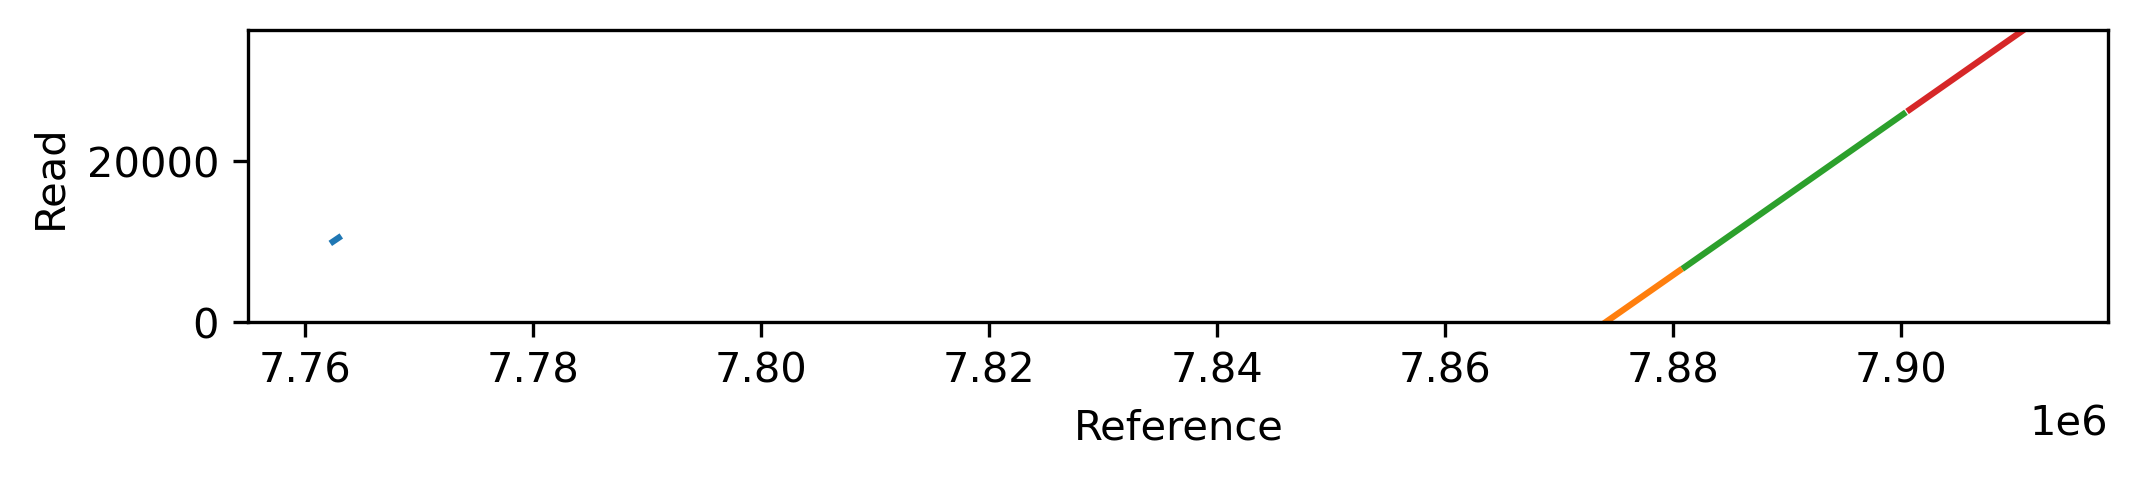

79c13c5d-edb1-4ff1-9674-502d81c131c6
[{'rs': 7763475, 're': 7764013, 'qs': 20730, 'qe': 21265}, {'rs': 7892589, 're': 7899219, 'qs': 15, 'qe': 6615}, {'rs': 7899740, 're': 7920626, 'qs': 7133, 'qe': 27838}] 27864


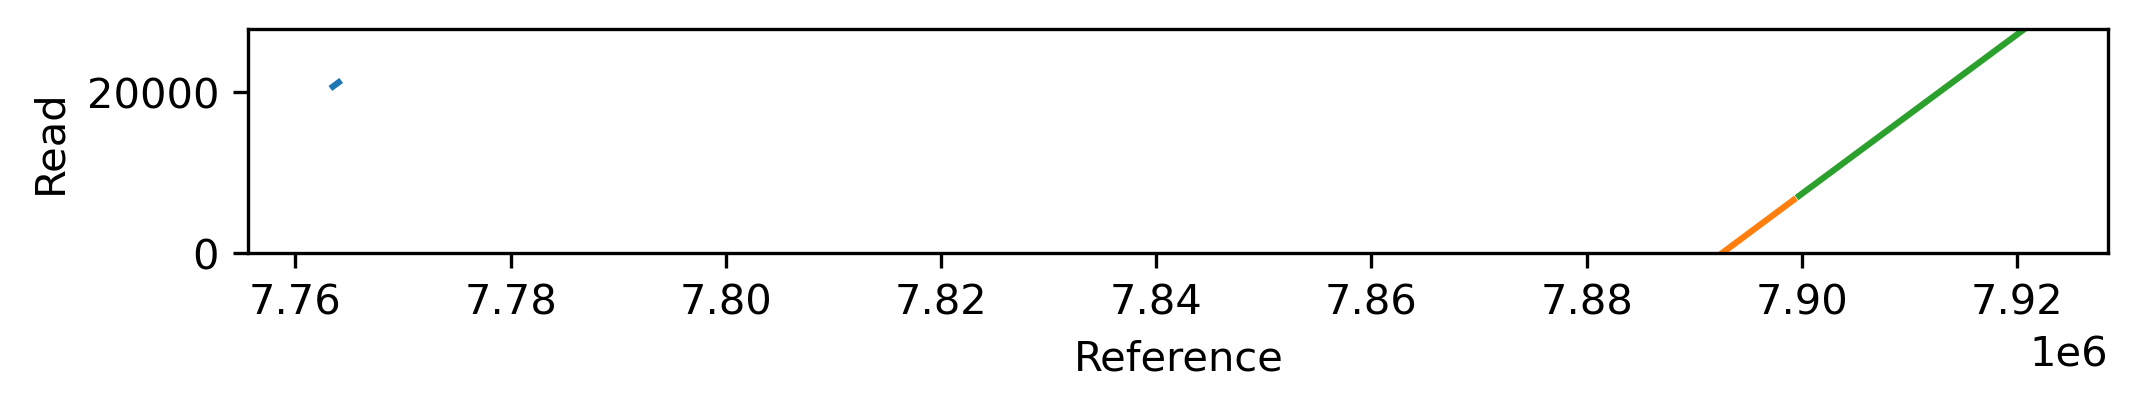

bb61eb02-2eea-4e4f-bb92-66afdd110891
[{'rs': 7728731, 're': 7764832, 'qs': 17, 'qe': 32509}, {'rs': 7728750, 're': 7771130, 'qs': 50, 'qe': 42171}, {'rs': 7768639, 're': 7771098, 'qs': 36208, 'qe': 38478}, {'rs': 7896055, 're': 7898379, 'qs': 45961, 'qe': 48143}] 80652


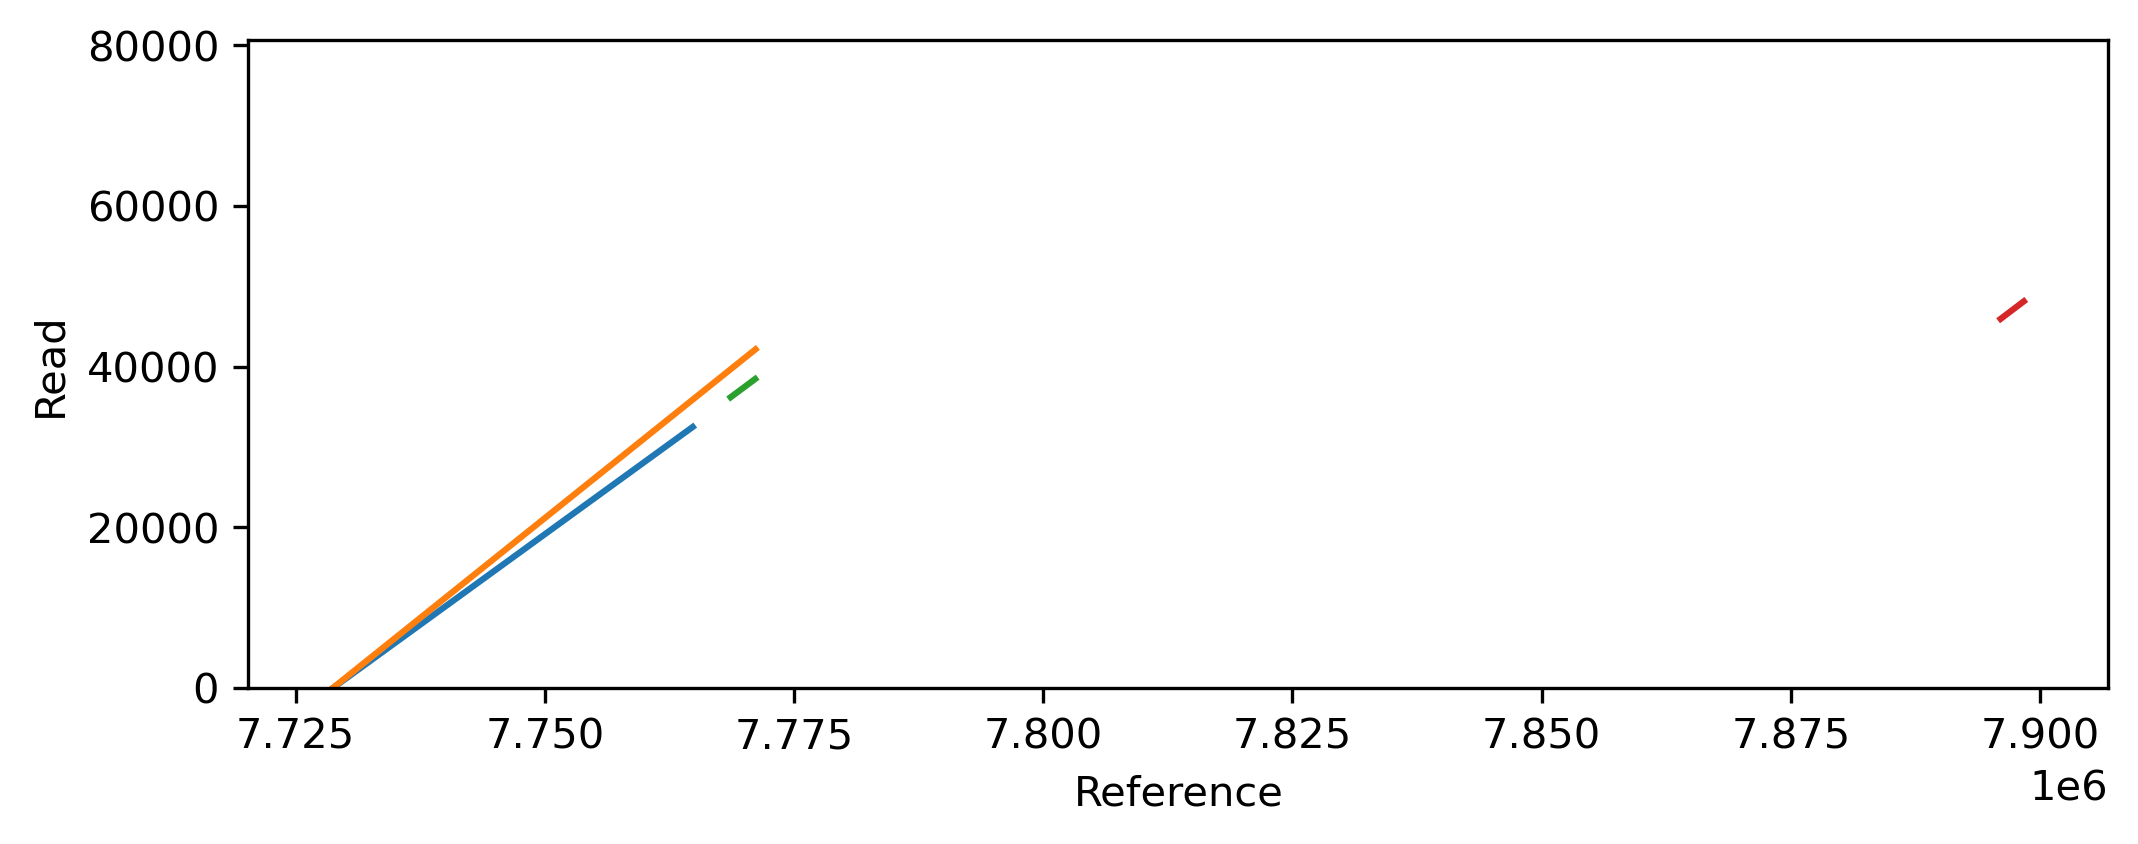

f5ad2b5d-c823-4740-b69c-0409e515bde6
[{'rs': 7763474, 're': 7765854, 'qs': 25071, 'qe': 27444}, {'rs': 7899741, 're': 7924939, 'qs': 2387, 'qe': 27432}] 27459


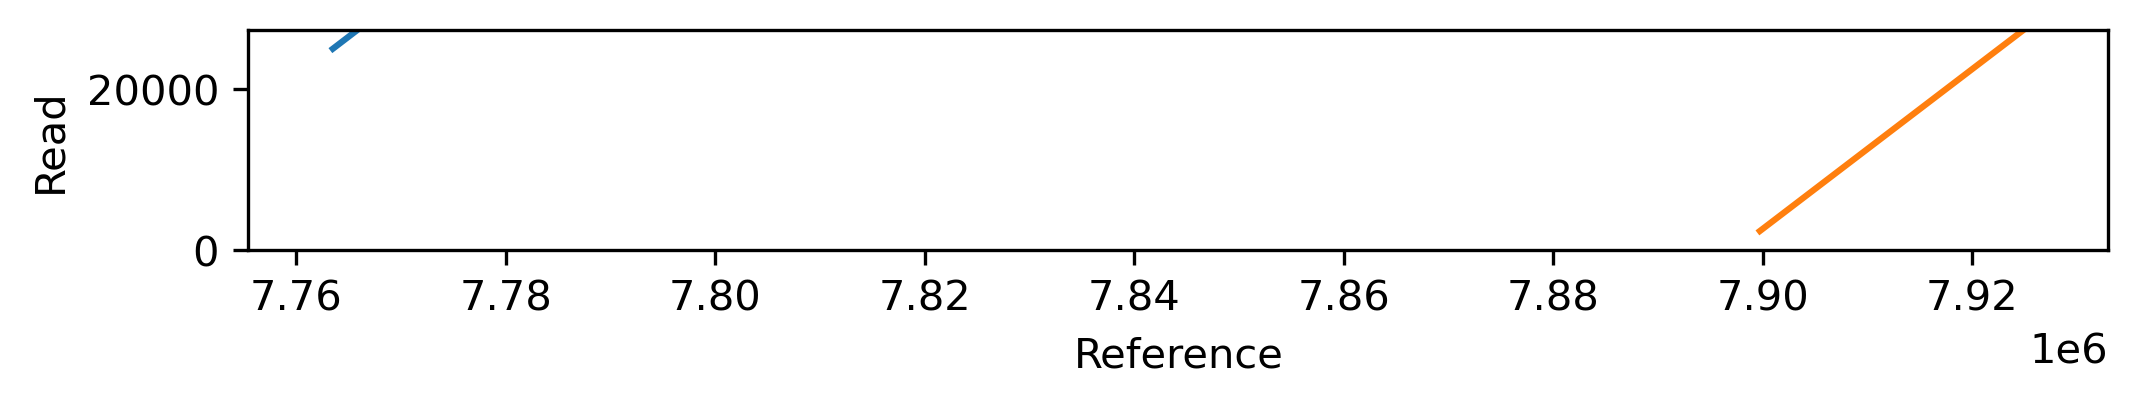

2cbdc8b8-dfb3-4f14-8ca3-43f34145306d
[{'rs': 7762292, 're': 7766224, 'qs': 17120, 'qe': 21019}, {'rs': 7900910, 're': 7918128, 'qs': 3913, 'qe': 21006}] 21034


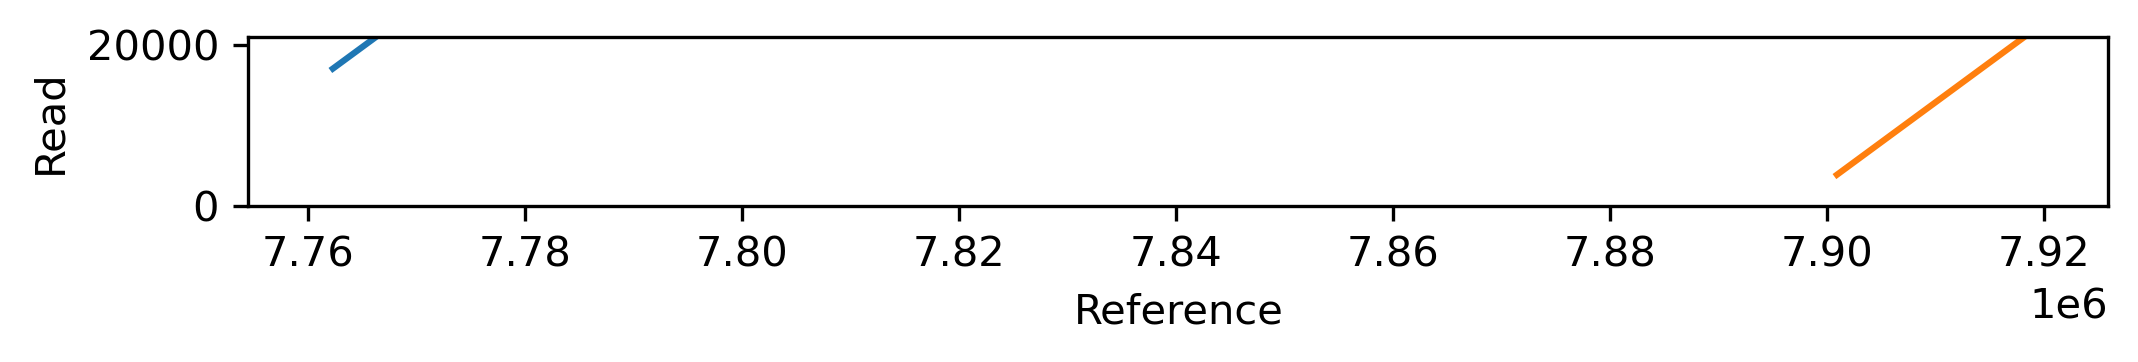

8e8f688e-ed5e-41ae-8e7d-8e90e3cd45f1
[{'rs': 7763531, 're': 7767665, 'qs': 12030, 'qe': 16132}, {'rs': 7895253, 're': 7895549, 'qs': 17, 'qe': 296}, {'rs': 7899684, 're': 7911972, 'qs': 4399, 'qe': 16403}] 16430


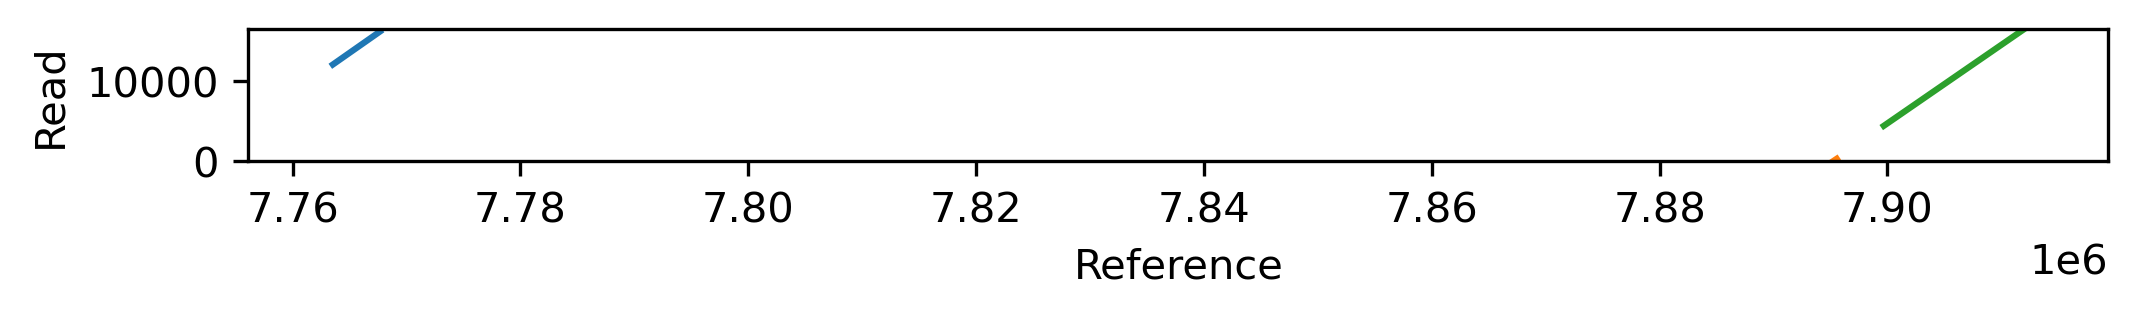

0393ed92-aa31-4814-81fc-86649f5a55ae
[{'rs': 7748569, 're': 7766448, 'qs': 29, 'qe': 17915}, {'rs': 7766958, 're': 7774885, 'qs': 18432, 'qe': 26291}, {'rs': 7896261, 're': 7896772, 'qs': 7877, 'qe': 8395}] 26309


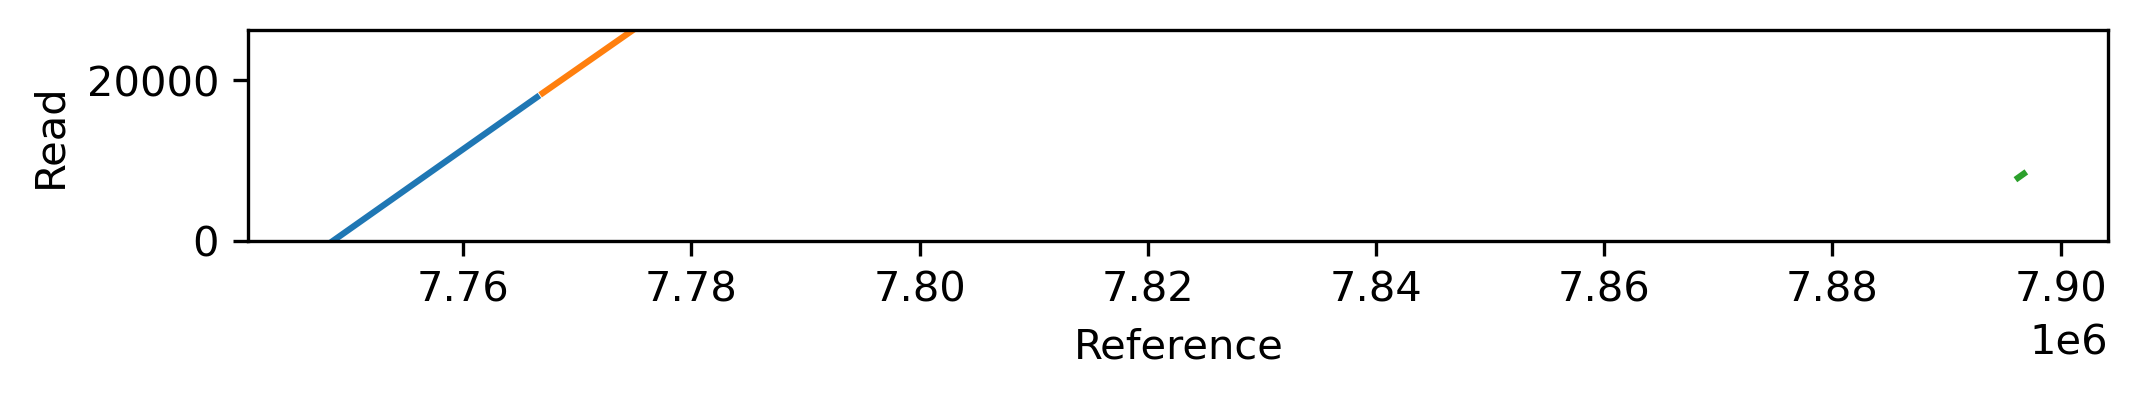

84dce493-fb5a-4f76-8686-c4214fd20c15
[{'rs': 7763471, 're': 7764194, 'qs': 21740, 'qe': 22468}, {'rs': 7899744, 're': 7921497, 'qs': 741, 'qe': 22452}] 22482


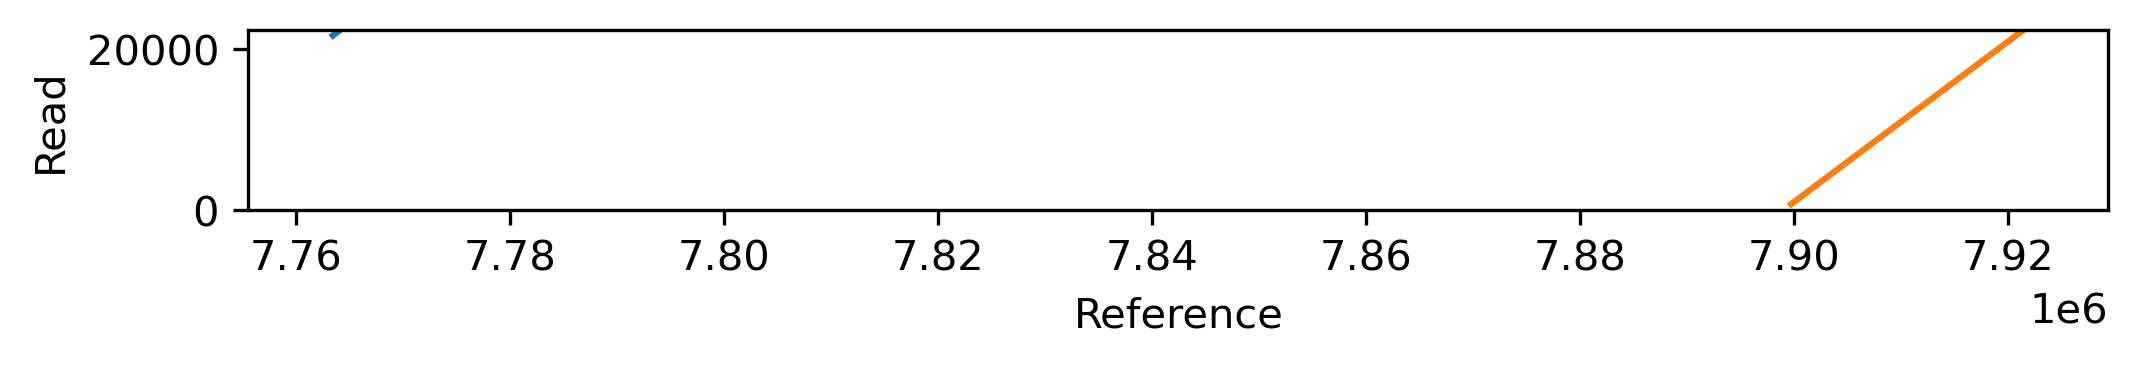

In [139]:
bamf = "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.bam"
start, end = 7720000, 7950000
plot_all_reads(bamf, np.random.choice(sr_spanning, 15), "Chrom_3", start, end)

I represent only 10 random reads here but I actually looked at many of them, all can be explained by repetitive regions, no read has a clear pattern of spanning the deletion...

Expected pattern (same color), y=ont; x=ref:
```
+                      X
+                     X
+                    X
+      X            X
+     X
+    X
+   X
+  X
+ X
+X
+++++++++++++++++++++++++++++++
          reference
```